# DebyeCalculator - Tutorial

**Authors:** Johansen & Anker et. al.

**Questions:** [frjo@di.ku.dk](frjo@di.ku.dk) and [andy@chem.ku.dk](andy@chem.ku.dk)

**Date:** August 2023

---
The `DebyeCalculator` class is a powerful tool for calculating the scattering intensity I(q) through the Debye scattering equation, the Total Scattering Structure Function S(q), the Reduced Total Scattering Function F(q), and the Reduced Atomic Pair Distribution Function G(r).
This class is optimized to run on GPUs, making it well-suited for large-scale simulations and nanoparticle analysis. It utilizes PyTorch to efficiently perform tensor computations and takes advantage of CUDA acceleration for enhanced speed.

In this notebook, we will demonstrate how to use the `DebyeCalculator` class to calculate I(Q), S(Q), F(Q) and G(r) for nanoparticles generated from a given atomic structure.

Let's get started with an overview of the `DebyeCalculator` class and its main functionalities.

First, import the relavant python packages by running the cell below

In [1]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from DebyeCalculator.debye_calculator import DebyeCalculator
from tests.produce_figure_data import produce_figures

---
## Creating an Instance of DebyeCalculator

To use the `DebyeCalculator` class, you need to create an instance of it. The constructor of the class allows you to set various parameters for the Debye scattering calculations. Here's how you can create an instance:

```python
from debye_calculator import DebyeCalculator

# Create an instance of DebyeCalculator
debye_calc = DebyeCalculator(
    qmin=0.0,
    qmax=30.0,
    qstep=0.1,
    qdamp=0.0,
    rmin=0.0,
    rmax=20.0,
    rstep=0.01,
    rthres=0.0,
    biso=0.0,
    device='cuda',
    batch_size=None,
    lorch_mod=False,
    radiation_type='xray',
    profile=False,
)

# Arguments for DebyeCalculator class

# Standard Debye parameters
qmin = 0.0        # Minimum Q (1/Å)
qmax = 30.0       # Maximum Q (1/Å)
qstep = 0.1       # Step size for Q (1/Å)
qdamp = 0.0       # Debye-Waller damping factor

# Parameters for pair distribution function (G(r)) calculations
rmin = 0.0        # Minimum R (Å)
rmax = 20.0       # Maximum R (Å)
rstep = 0.01      # Step size for R (Å)
rthres = 0.0      # Lower threshold (Å) radial distance for G(r) calculations

# Debye-Weller isotropic atomic displacement factor
biso = 0.0

# Device selection
device = 'cuda'   # Use 'cuda' for GPU or 'cpu' for CPU

# Batch size for pairwise distance calculations (if not specified, it will be automatically determined)
batch_size = None

# Lorch modification factor for G(r) calculations
lorch_mod = False

# Radiation type for scattering calculations
radiation_type = 'xray'  # Use 'xray' or 'neutron'

# Activate profiler
profile = False

```

In [2]:
# Create an instance of DebyeCalculator
debye_calc = DebyeCalculator(device='cuda', profile=True, qmin=1, qmax=25, qstep=0.1, biso=0.3)
print(debye_calc)

DebyeCalculator{'qmin': 1, 'qmax': 25, 'qdamp': 0.04, 'qstep': 0.1, 'rmin': 0.0, 'rmax': 20.0, 'rstep': 0.01, 'rthres': 0.0, 'biso': 0.3}


We can also change the object parameters on the fly using the build-in ``update_parameters`` method

In [3]:
debye_calc.update_parameters(qmin=0.8)
print(debye_calc)

DebyeCalculator{'qmin': 0.8, 'qmax': 25, 'qdamp': 0.04, 'qstep': 0.1, 'rmin': 0.0, 'rmax': 20.0, 'rstep': 0.01, 'rthres': 0.0, 'biso': 0.3}


---
## Generating Nanoparticles
In this section, we will demonstrate how to use the utility method `generate_nanoparticle` included in the `DebyeCalculator` class to generate nanoparticles. The utility function allows you to create a nanoparticle supercell based on the input atomic structure from `.cif` files. If you don't care about looking at the particle and you just want to analyse its I(Q), S(Q), F(Q) or G(r) you can skip this section.

**Note:** The utility method strictly takes `.cif` files as input since it generates nanoparticles from supercells of the unit cells provided by the `.cif` files.

**Usage:**
To create nanoparticles, use the following function:

```python
from debye_calculator import DebyeCalculator

debye_calc = DebyeCalculator()
debye_calc.generate_nanoparticle(structure_path, radii, sort_atoms=True)
```

**Parameters:**
* `structure_path`: The path to the input atomic structure `.cif` file.
* `radii`: A list (or single value) of radii for which nanoparticles will be generated.
* `sort_atoms`: (Optional) Whether to sort the atoms in the nanoparticle based on distance to the center. Defaults to `True`.

**Output:**
The function returns a list of nanoparticle supercells, each corresponding to a specific radius from the radii list.
It also returns a list of nanoparticle sizes (diameters) for each nanoparticle generated.

**Example:**
```python
# Example usage with an .cif file
structure_path = "path/to/atomic_structure.cif"
radii = [10, 15, 20]  # Radii for nanoparticle generation

# Generate nanoparticles
nano_particles, particle_sizes = debye_calc.generate_nanoparticle(structure_path, radii)
```

In [4]:
# Load the structure file
structure_path = 'data/AntiFluorite_Co2O.cif'

# Generate nanoparticles
radii = [5.0, 10.0, 15.0]  # Sample radii for nanoparticles
nano_particles, nano_sizes = debye_calc.generate_nanoparticles(structure_path, radii)

Generating nanoparticles in range: [5.0,15.0]:   0%|          | 0/3 [00:00<?, ?it/s]

---
## Calculating I(Q) and G(r) from `.xyz`-file with <i>DebyeCalculator</i>

Let's explore how to use the `DebyeCalculator` class to calculate the scattering intensity (I(Q)) and pair distribution function (G(r)) for these nanoparticles.

#### Calculating I(Q):

To calculate the scattering intensity I(Q) for a nanoparticle, you can use the `iq` method of the `DebyeCalculator` class. This method takes the `.xyz` file and returns the scattering intensity I(Q) at the specified Q values.

```python
# Example usage to calculate I(Q) for a single nanoparticle
from DebyeCalculator import DebyeCalculator

# Create an instance of DebyeCalculator with appropriate parameters
calculator = DebyeCalculator(qmin=0.0, qmax=30.0, qstep=0.1, qdamp=0.0)

# Load a single nanoparticle from a .xyz file (replace "path/to/nanoparticle.xyz" with your file path)
nanoparticle_xyz_file = "path/to/nanoparticle.xyz"
q_values, scattering_intensity = calculator.iq(nanoparticle_xyz_file)

```
**Note:** The example above demonstrates how to calculate I(Q) for a single nanoparticle using an `.xyz` file. You can alternatively parse an `.cif` file as demonstrated in the next section 

#### Calculating G(r):

To calculate the pair distribution function G(r) for a nanoparticle, you can use the `gr` method of the `DebyeCalculator` class:
```python

# Example usage to calculate G(r) for a single nanoparticle
from DebyeCalculator import DebyeCalculator

# Create an instance of DebyeCalculator with appropriate parameters
debye_calc = DebyeCalculator(qmin=0.0, qmax=30.0, qstep=0.1, qdamp=0.0, rmin=0.0, rmax=20.0, rstep=0.01)

# Load a single nanoparticle from a .xyz file (replace "path/to/nanoparticle.xyz" with your file path)
nanoparticle_xyz_file = "path/to/nanoparticle.xyz"
r_values, pair_distribution_function = debye_calc.gr(nanoparticle_xyz_file)

```

---
## Calculating I(Q) and G(r) from `.cif`-file with <i>DebyeCalculator</i>

Now that we have nanoparticle supercells ready, let's explore how to use the `DebyeCalculator` class to calculate the scattering intensity (I(Q)) and pair distribution function (G(r)) for these nanoparticles.

#### Calculating I(Q):

To calculate the scattering intensity I(Q) for a nanoparticle, you can use the `iq` method of the `DebyeCalculator` class. This method takes the `.cif` file and a set of radii, generates particles based on those radii and returns a list of the scattering intensities for every particle in the set, at the specified Q values.

```python
# Example usage to calculate I(Q) for a single nanoparticle
from DebyeCalculator import DebyeCalculator

# Create an instance of DebyeCalculator with appropriate parameters
calculator = DebyeCalculator(qmin=0.0, qmax=30.0, qstep=0.1, qdamp=0.0)

# Load a crystal_file from a .cif file (replace "path/to/crystalfile.cif" with your file path)
# and generate different sizes particles
radii = [5.0, 10.0]
crystal_file = "path/to/crystalfile.cif"
q_values, list_of_scattering_intensities = calculator.iq(structure_path = crystal_file, radii = radii)

```

#### Calculating G(r):

To calculate the pair distribution function G(r) for a nanoparticle, you can use the `gr` method of the `DebyeCalculator` class:

```python

# Example usage to calculate G(r) for a single nanoparticle
from DebyeCalculator import DebyeCalculator

# Create an instance of DebyeCalculator with appropriate parameters
debye_calc = DebyeCalculator(qmin=0.0, qmax=30.0, qstep=0.1, qdamp=0.0, rmin=0.0, rmax=20.0, rstep=0.01)

# Load a crystal_file from a .cif file (replace "path/to/crystalfile.cif" with your file path)
# and generate different sizes particles
radii = [5.0, 10.0]
crystal_file = "path/to/crystalfile.cif"
r_values, list_pair_distribution_functions = calculator.gr(structure_path = crystal_file, radii = radii)

```

---
The code below showcases how to calculate I(Q), F(Q) and G(r) using a `.cif` file and a set of radii

In [5]:
from diffpy.structure import loadStructure
from diffpy.srreal.pdfcalculator import DebyePDFCalculator

In [6]:
# Create an instance of DebyeCalculator
debye_calc = DebyeCalculator(device='cuda', profile=True, qmin=1, qmax=25, qstep=0.1, biso=0.3, qdamp=0.0)

radii = [5.0, 10.0]
q, iq_dc = debye_calc.iq(structure_path = 'data/AntiFluorite_Co2O.cif', radii = radii)
_, fq_dc = debye_calc.fq(structure_path = 'data/AntiFluorite_Co2O.cif', radii = radii)
r, gr_dc = debye_calc.gr(structure_path = 'data/AntiFluorite_Co2O.cif', radii = radii)
debye_calc.update_parameters(qmin=0, qmax=2, qstep=0.01)
q_sas, sas_dc = debye_calc.iq(structure_path = 'data/AntiFluorite_Co2O.cif', radii = [5.0, 10.0])

Nanoparticle 1: Size: 10.000 Å


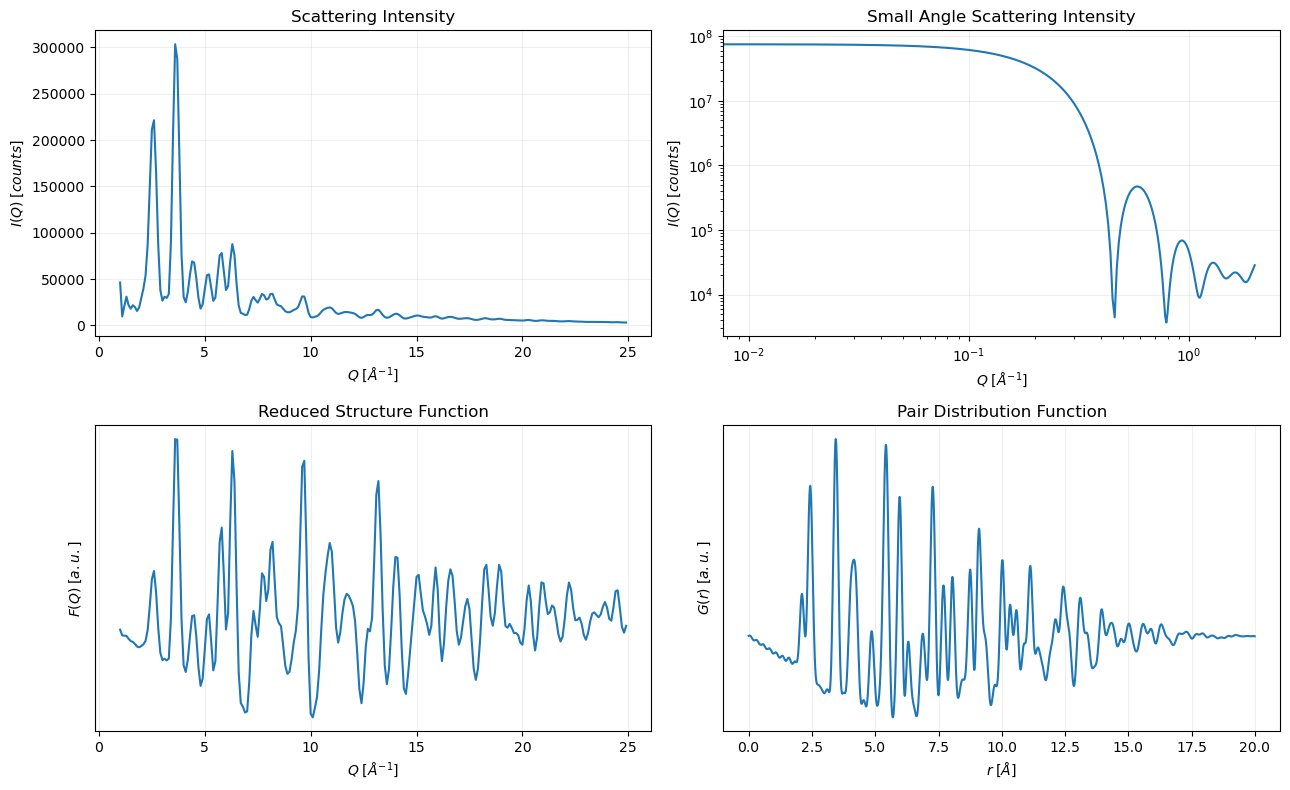

-------------------------
Nanoparticle 2: Size: 20.000 Å


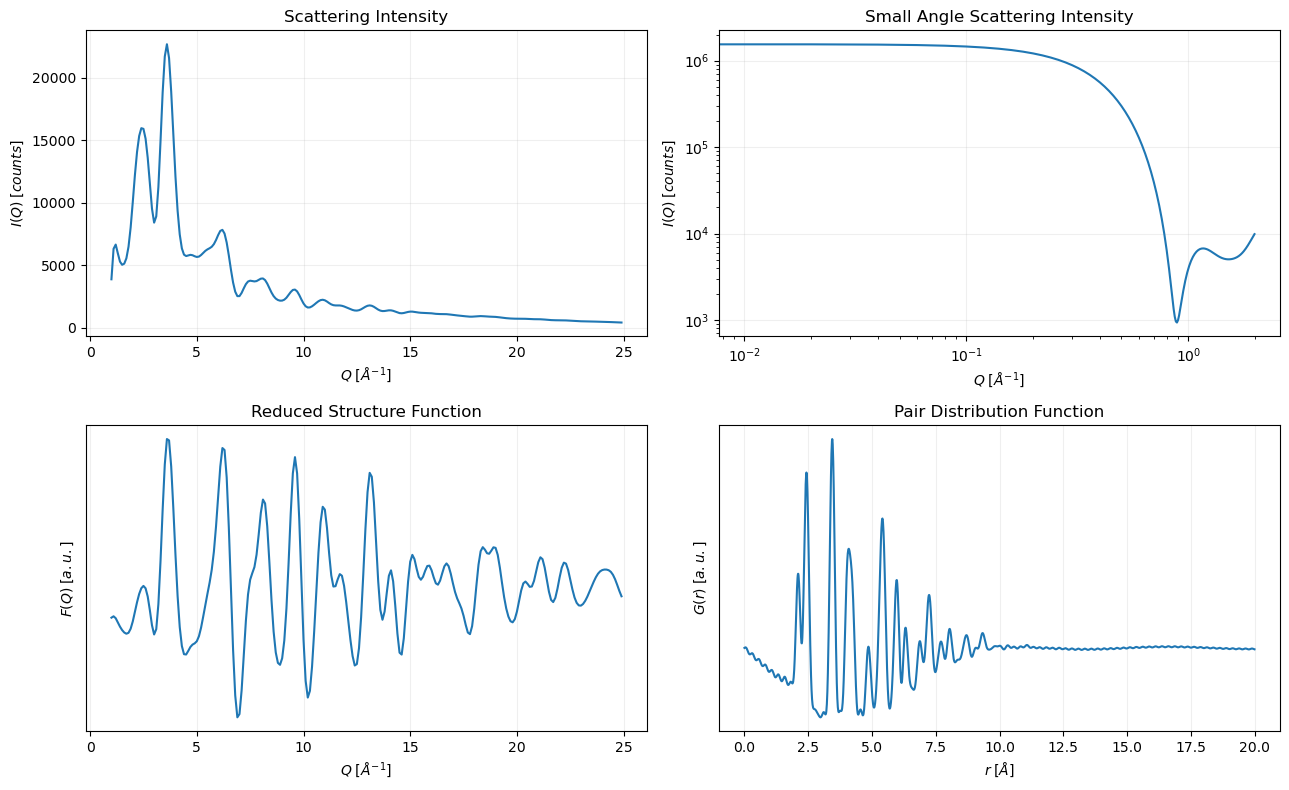

-------------------------


In [7]:
# Print nanoparticle sizes and plot their corresponding I(Q), F(Q) and G(r)
for i, (size, iq, sas, fq, gr) in enumerate(zip(radii, iq_dc, sas_dc, fq_dc, gr_dc)):
    print(f"Nanoparticle {i+1}: Size: {size*2:.3f} Å")
    fig, ((ax_iq, ax_sas), (ax_fq, ax_gr)) = plt.subplots(2,2, figsize=(13,8))

    ax_iq.plot(q,iq)
    ax_iq.set(xlabel='$Q \; [\AA^{-1}]$', ylabel='$I(Q) \; [counts]$')
    ax_iq.grid(alpha=0.2)
    ax_iq.set_title('Scattering Intensity')
    
    ax_sas.plot(q_sas, sas)
    ax_sas.set(xlabel='$Q \; [\AA^{-1}]$', ylabel='$I(Q) \; [counts]$')
    ax_sas.grid(alpha=0.2)
    ax_sas.set_yscale('log')
    ax_sas.set_xscale('log')
    ax_sas.set_title('Small Angle Scattering Intensity')
    
    ax_fq.plot(q,fq/max(fq))
    ax_fq.set(xlabel='$Q \; [\AA^{-1}]$', ylabel='$F(Q)\; [a.u.]$', yticks=[])
    ax_fq.grid(alpha=0.2)
    ax_fq.set_title('Reduced Structure Function')
    
    ax_gr.plot(r,gr/max(gr))
    ax_gr.set(xlabel='$r \; [\AA]$', ylabel='$G(r) \; [a.u.]$', yticks=[])
    ax_gr.grid(alpha=0.2)
    ax_gr.set_title('Pair Distribution Function')
    
    fig.tight_layout()
    plt.show()

    print("-------------------------")

## Generation Comparison: DebyeCalculator vs. DiffPy CMI
The figures compares the generated data to that generated using the DiffPy-CMI package.

In [8]:
from DebyeCalculator.utility.SASCalculator import SASCalculator
import tempfile
import os
from ase.io import write
from tqdm.auto import tqdm

In [9]:
structure_path = 'data/icsd_001504_cc_r6_lc_2.85_6_tetragonal.xyz'

# Create an instance of DebyeCalculator
debye_calc = DebyeCalculator(device='cuda', qmin=1, qmax=40, qstep=0.01, biso=0.1, rmax=20, batch_size=4000)
dbc = DebyePDFCalculator(rmin=debye_calc.rmin, rmax=debye_calc.rmax, rstep=debye_calc.rstep,
                         qmin=debye_calc.qmin, qmax=debye_calc.qmax, qdamp=debye_calc.qdamp,
                         qstep=debye_calc.qstep)

# Calculate I(Q), F(Q) and G(r) for the nanoparticles
r, q, iq_dc, _, fq_dc, gr_dc = debye_calc._get_all(structure_path)

debye_calc.update_parameters(qmin=0, qmax=3)
q_sas, sas_dc = debye_calc.iq(structure_path)
debye_calc.update_parameters(qmin=1, qmax=40)

diffpy_structure = loadStructure(structure_path)

diffpy_structure.B11 = debye_calc.biso
diffpy_structure.B22 = debye_calc.biso
diffpy_structure.B33 = debye_calc.biso
diffpy_structure.B12 = 0
diffpy_structure.B13 = 0
diffpy_structure.B23 = 0

r_dp, gr_dp = dbc(diffpy_structure)
fq_dp = dbc.fq[int(debye_calc.qmin/debye_calc.qstep):]

sc = SASCalculator(rmin=debye_calc.rmin, rmax=debye_calc.rmax, rstep=debye_calc.rstep,
                   qmin=debye_calc.qmin, qmax=debye_calc.qmax, qdamp=debye_calc.qdamp)

sc.qstep = debye_calc.qstep
q_dp_full, iq_dp_full = sc(diffpy_structure, qmin=debye_calc.qmin)
iq_dp = iq_dp_full[int(debye_calc.qmin/debye_calc.qstep):]
q_dp = q_dp_full[int((debye_calc.qmin)/debye_calc.qstep):]

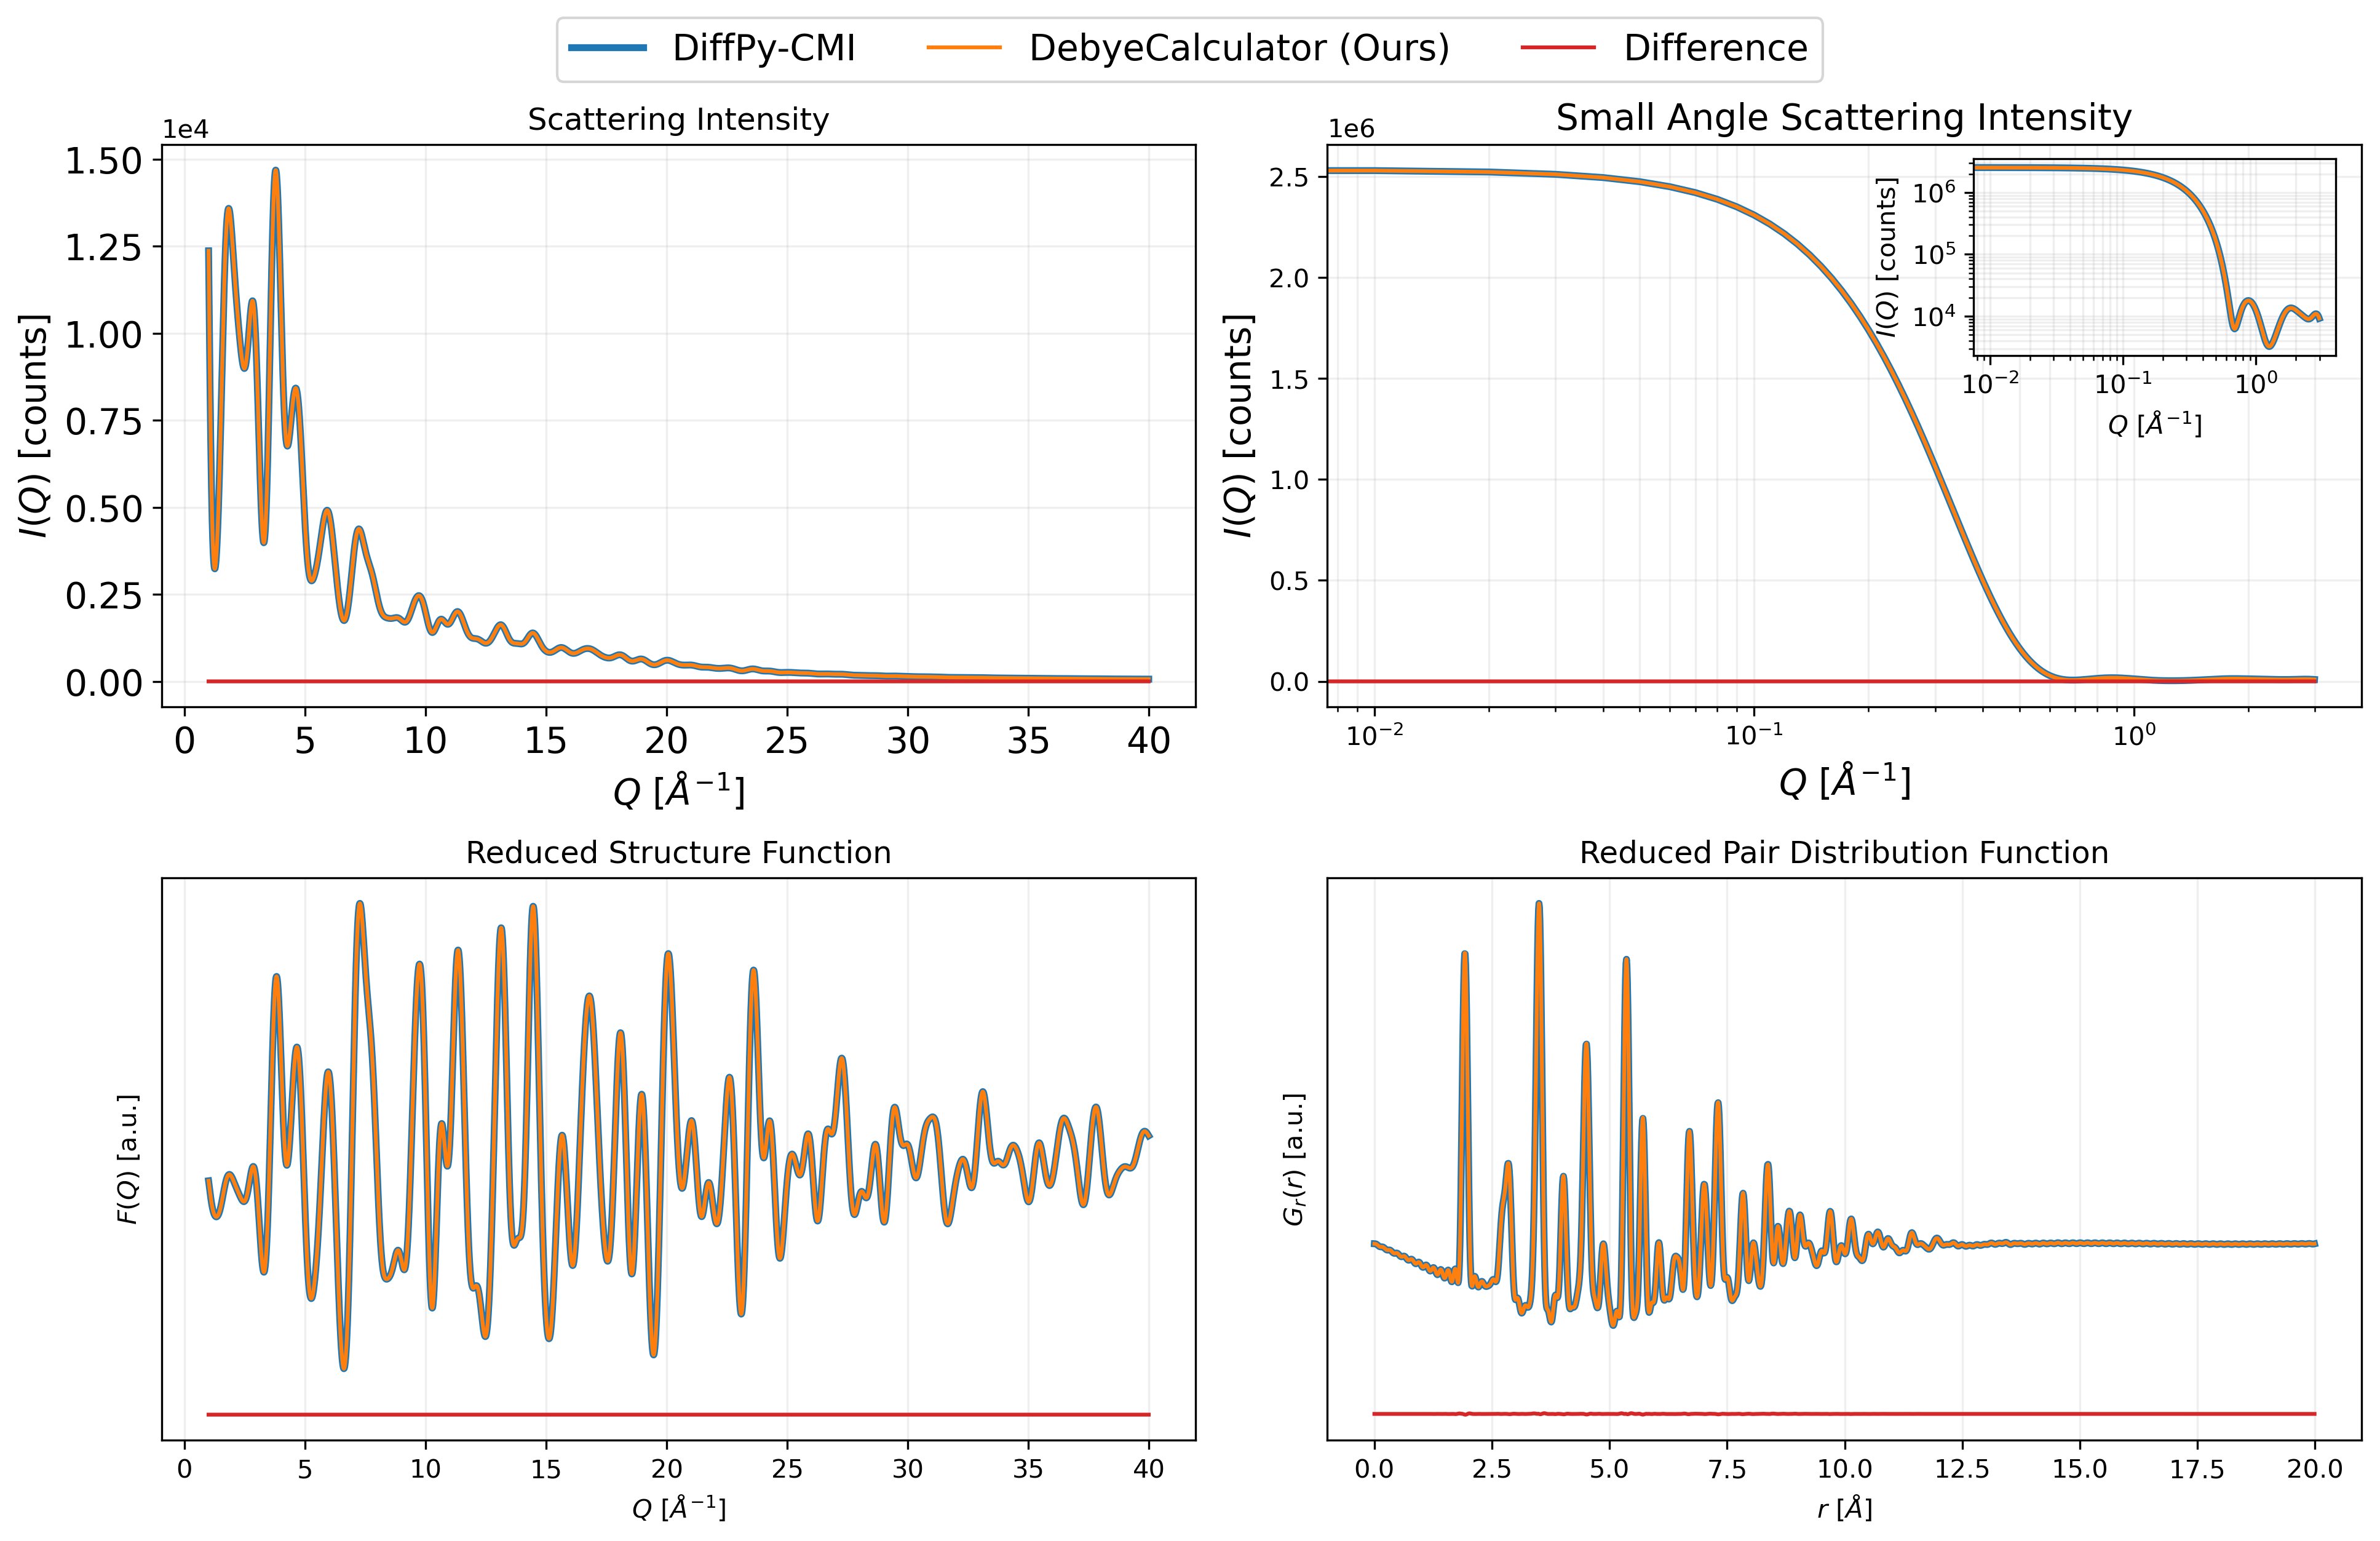

In [28]:
fig, ((ax_iq, ax_sas), (ax_fq, ax_gr)) = plt.subplots(2,2, figsize=(13,8), dpi=300)

label_font_size = 14
    
ax_iq.plot(q,iq_dp, label='DiffPy-CMI', lw=2.7)
ax_iq.plot(q,iq_dc, label='DebyeCalculator (Ours)')
ax_iq.plot(q,iq_dp-iq_dc, c='#d62728', label='Difference')
ax_iq.set_title('Scattering Intensity', fontsize=label_font_size)
ax_iq.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax_iq.set_xlabel('$Q$ [$\AA^{-1}$]', fontsize=label_font_size)
ax_iq.set_ylabel('$I(Q)$ [counts]', fontsize=label_font_size)
ax_iq.tick_params(axis='both', labelsize=label_font_size)
ax_iq.grid(alpha=0.2)
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=label_font_size, ncol=3)  # Move legend to the top

ax_sas.plot(q_sas, iq_dp_full[:len(q_sas)], label='DiffPy-CMI', lw=2.7)
ax_sas.plot(q_sas, sas_dc, label='DebyeCalculator (Ours)')
ax_sas.plot(q_sas, iq_dp_full[:len(q_sas)]-sas_dc, c='#d62728', label='Difference')
ax_sas.set_xlabel('$Q$ [$\AA^{-1}$]', fontsize=label_font_size)
ax_sas.set_ylabel('$I(Q)$ [counts]', fontsize=label_font_size)
ax_sas.grid(alpha=0.2, which='both')
ax_sas.set_xscale('log')
ax_sas.set_title('Small Angle Scattering Intensity', fontsize=label_font_size)
ax_sas.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax_sas_inset = ax_sas.inset_axes([0.625, 0.625, 0.35, 0.35])
ax_sas_inset.plot(q_sas, iq_dp_full[:len(q_sas)], label='DiffPy-CMI', lw=2.7)
ax_sas_inset.plot(q_sas, sas_dc, label='DebyeCalculator (Ours)')
ax_sas_inset.set_yscale('log')
ax_sas_inset.set_xscale('log')
ax_sas_inset.set(xlabel='$Q$ [$\AA^{-1}$]', ylabel='$I(Q)$ [counts]')
ax_sas_inset.grid(alpha=0.2, which='both')

ax_fq.plot(q,fq_dp/max(fq_dp), label='DiffPy-CMI', lw=2.7)
ax_fq.plot(q,fq_dc/max(fq_dc), label='DebyeCalculator (Ours)')
ax_fq.plot(q, fq_dp/max(fq_dp) - fq_dc/max(fq_dc) - 1, c='#d62728', label='Difference')
ax_fq.set_xlabel('$Q$ [$\AA^{-1}$]', fontsize=label_font_size)
ax_fq.set_ylabel('$F(Q)$ [a.u.]', fontsize=label_font_size)
ax_fq.set_yticks([])
ax_fq.grid(alpha=0.2)
ax_fq.set_title('Reduced Structure Function', fontsize=label_font_size)

ax_gr.plot(r_dp,gr_dp/max(gr_dp), label='DiffPy-CMI', lw=2.7)
ax_gr.plot(r,gr_dc/max(gr_dc), label='DebyeCalculator (Ours)')
ax_gr.plot(r_dp, gr_dp/max(gr_dp) - gr_dc/max(gr_dc) - 0.5, c='#d62728', label='Difference')
ax_gr.set(xlabel='$r$ [$\AA$]', ylabel='$G_r(r)$ [a.u.]',
ax_gr.set_yticks=[])
ax_gr.grid(alpha=0.2)
ax_gr.set_title('Reduced Pair Distribution Function', fontsize=label_font_size)

fig.tight_layout()
# fig.savefig('figures/figure_S1.png', dpi=300, bbox_inches='tight')

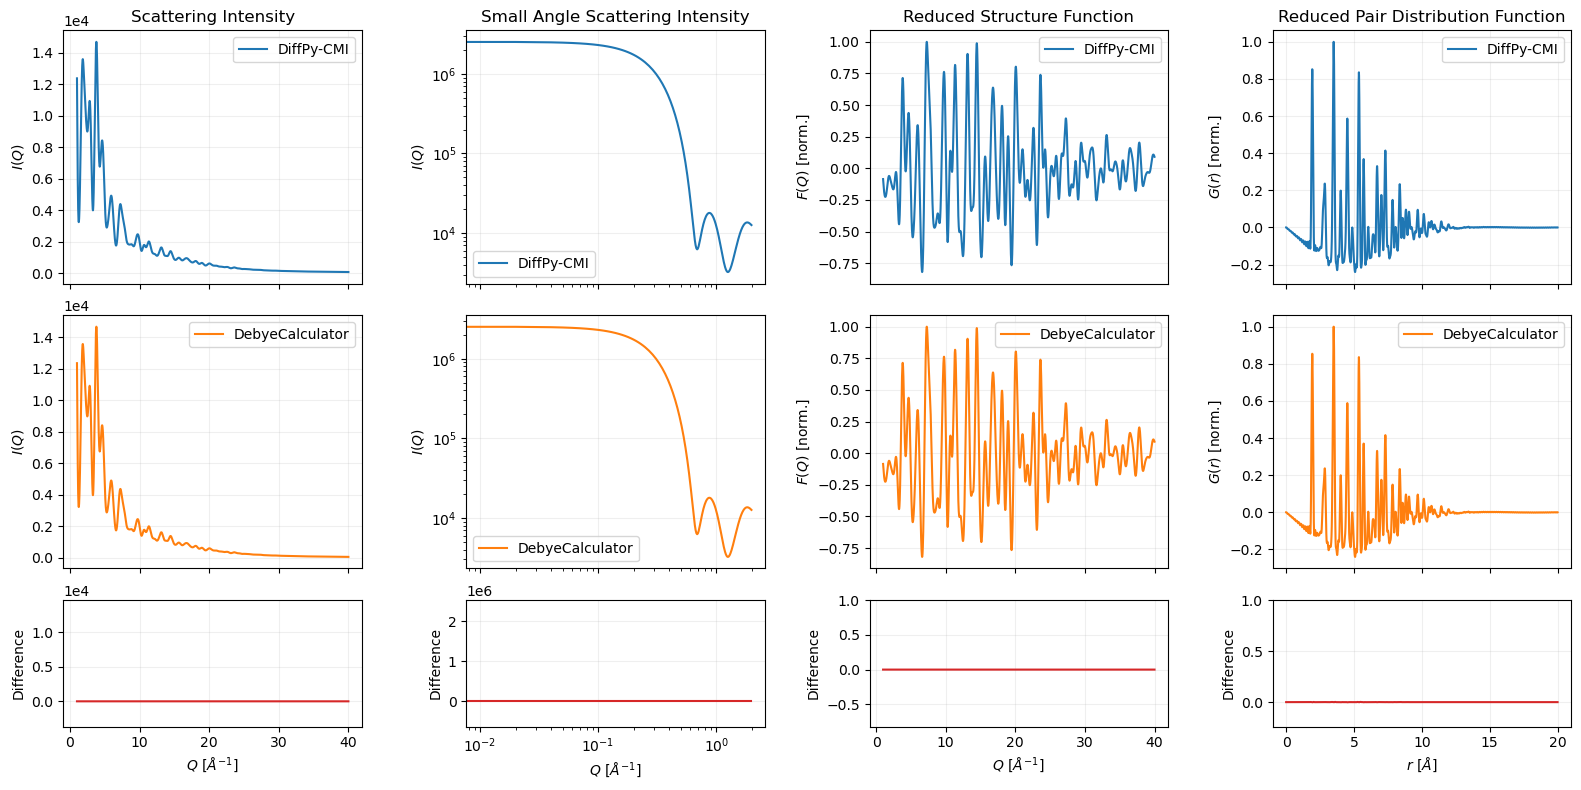

In [11]:
fig, axes = plt.subplots(3,4, figsize = (16, 8), gridspec_kw={'height_ratios':[1,1,0.5]})

# Scattering
for ax in axes[:,0]:
    ax.grid(alpha=0.2)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
axes[0,0].plot(q,iq_dp, label='DiffPy-CMI')
axes[0,0].set(ylabel='$I(Q)$', title='Scattering Intensity', xticklabels=[])
axes[0,0].legend(['DiffPy-CMI'])
axes[1,0].plot(q,iq_dc, label='DebyeCalculator',  c='#ff7f0e')
axes[1,0].set(ylabel='$I(Q)$', xticklabels=[])
axes[1,0].legend(['DebyeCalculator'])
axes[2,0].plot(q,iq_dp-iq_dc, c='#d62728', label='Difference')
axes[2,0].set(ylabel='Difference', xlabel='$Q$ [$\AA^{-1}$]', ylim=(-iq_dp.max()/4, iq_dp.max()))

# Small Angle Scattering
for ax in axes[:,1]:
    ax.grid(alpha=0.2)
    ax.set_xscale('log')
    
axes[0,1].plot(q_sas, iq_dp_full[:len(q_sas)], label='DiffPy-CMI')
axes[0,1].set(ylabel='$I(Q)$', title='Small Angle Scattering Intensity', xticklabels=[])
axes[0,1].set_yscale('log')
axes[0,1].legend()
axes[1,1].plot(q_sas, sas_dc, label='DebyeCalculator', c='#ff7f0e')
axes[1,1].set(ylabel='$I(Q)$', xticklabels=[])
axes[1,1].set_yscale('log')
axes[1,1].legend()
axes[2,1].plot(q_sas, iq_dp_full[:len(q_sas)]-sas_dc, c='#d62728', label='Difference')
axes[2,1].set(ylabel='Difference', xlabel='$Q$ [$\AA^{-1}$]', ylim=(-(iq_dp_full[:len(q_sas)]).max()/4, (iq_dp_full[:len(q_sas)]).max()))


# Reduced Structure Function
for ax in axes[:,2]:
    ax.grid(alpha=0.2)   

axes[0,2].plot(q,fq_dp/max(fq_dp), label='DiffPy-CMI')
axes[0,2].set(ylabel='$F(Q)$ [norm.]', title='Reduced Structure Function', xticks=[])
axes[0,2].legend()
axes[1,2].plot(q,fq_dc/max(fq_dc), label='DebyeCalculator', c='#ff7f0e')
axes[1,2].set(ylabel='$F(Q)$ [norm.]', xticklabels=[])
axes[1,2].legend()
axes[2,2].plot(q, fq_dp/max(fq_dp) - fq_dc/max(fq_dc), c='#d62728', label='Difference')
axes[2,2].set(ylabel='Difference', xlabel='$Q$ [$\AA^{-1}$]', ylim=((fq_dp/max(fq_dp)).min(), (fq_dp/max(fq_dp)).max())) 

    
# Reduced Pair Distribution Function
for ax in axes[:,3]:
    ax.grid(alpha=0.2) 
    
axes[0,3].plot(r_dp,gr_dp/max(gr_dp), label='DiffPy-CMI')
axes[0,3].set(ylabel='$G(r)$ [norm.]', title='Reduced Pair Distribution Function', xticklabels=[])
axes[0,3].legend()
axes[1,3].plot(r,gr_dc/max(gr_dc), label='DebyeCalculator', c='#ff7f0e')
axes[1,3].set(ylabel='$G(r)$ [norm.]', xticklabels=[])
axes[1,3].legend()
axes[2,3].plot(r_dp, gr_dp/max(gr_dp) - gr_dc/max(gr_dc), c='#d62728', label='Difference')
axes[2,3].set(ylabel='Difference', xlabel='$r$ [$\AA$]', ylim=((gr_dp/max(gr_dp)).min(), (gr_dp/max(gr_dp)).max()))

fig.tight_layout()
fig.subplots_adjust(wspace=0.35,hspace=0.15)
plt.show()

# fig.savefig('figures/figure_S1.png')

---
## Useful For Developers

### Profiling Performance with DebyeCalculator

The `DebyeCalculator` class comes with a built-in profiler that allows you to measure the time taken to execute specific parts of the code. This can be helpful in identifying performance bottlenecks and optimizing your calculations.

The profiler in `DebyeCalculator` is an instance of the `Profiling` class, which tracks the time taken by various methods in the class and provides summary statistics.

#### Profiler Demonstration

The next cell demonstrates the use of the profiler by generating nanoparticles of increasing sizes using the `generate_nanoparticle` function. We will measure the time taken to generate nanoparticles of different sizes and analyze the results using the profiler.

Let's get started!

In [12]:
from tqdm.auto import trange

In [13]:
# Load the structure file
structure_path = 'data/AntiFluorite_Co2O.cif'

# Profiling for single particle:
debye_calc = DebyeCalculator(device='cuda', profile=True, qmin=1, qmax=25, qstep=0.1, biso=0.3, batch_size=5000)
for _ in trange(10):
    r, gr = debye_calc.gr(structure_path, radii = 10.0)

print(debye_calc.profiler.summary(prefix='Times per data generation:'))

  0%|          | 0/10 [00:00<?, ?it/s]

Times per data generation:
   -> Setup structures and form factors: 70.917ms +- 6.909ms (69.23%) 
   -> I(Q): 31.203ms +- 3.600ms (30.46%) 
   -> Batching and Distances: 0.123ms +- 0.032ms (0.12%) 
   -> G(r): 0.067ms +- 0.024ms (0.07%) 
   -> S(Q): 0.067ms +- 0.028ms (0.07%) 
   -> Modifications, Qdamp/Lorch: 0.053ms +- 0.033ms (0.05%) 
   -> F(Q): 0.008ms +- 0.002ms (0.01%) 
Total: 102.439ms


In [14]:
# Load the structure file
structure_path = 'data/sim_Ag2O_cc_r4_lc_2.64_4_AntiFlourite.xyz'

# Profiling for single particle:
debye_calc = DebyeCalculator(device='cuda', profile=True, qmin=1, qmax=25, qstep=0.1, biso=0.3, batch_size=5000)
for _ in trange(10):
    r, gr = debye_calc.gr(structure_path)

print(debye_calc.profiler.summary(prefix='Times per data generation:'))

  0%|          | 0/10 [00:00<?, ?it/s]

Times per data generation:
   -> Setup structures and form factors: 1.370ms +- 0.658ms (60.58%) 
   -> I(Q): 0.732ms +- 0.437ms (32.38%) 
   -> G(r): 0.052ms +- 0.007ms (2.32%) 
   -> Modifications, Qdamp/Lorch: 0.042ms +- 0.009ms (1.87%) 
   -> Batching and Distances: 0.033ms +- 0.012ms (1.47%) 
   -> S(Q): 0.025ms +- 0.011ms (1.08%) 
   -> F(Q): 0.007ms +- 0.001ms (0.30%) 
Total: 2.262ms


---
## Speed Comparison: DebyeCalculator vs. DiffPy-CMI

In this section, we will compare the speed of calculations between two different methods for calculating the Debye scattering, namely:
1. The `DebyeCalculator` class implemented in this notebook
2. The `DebyePDFCalculator` from the DiffPy-CMI library

We will perform the following steps:
1. Use the `generate_nanoparticle` function to create nanoparticles of different sizes.
2. Calculate I(Q) and G(r) using the `DebyeCalculator` class for each nanoparticle.
3. Calculate I(Q) and G(r) using the `DebyePDFCalculator` from DiffPy-CMI for each nanoparticle.
4. Compare the time taken by both methods using the built-in profiler.

Note that to use the `DebyePDFCalculator` from DiffPy-CMI, you need to have DiffPy-CMI installed in your Python environment. If you don't have it installed, you can install it using the following command:

```python
!pip install diffpy-cmi
```
**Note**: Installing the DiffPy-CMI library might require a python version of 3.7 or later or 2.7. For more information visit [Diffpy-CMI](https://www.diffpy.org/products/diffpycmi/index.html).

In [15]:
# Check if you alread have the datafiles before running this cell, so you don't have to wait
args = dict(
    cif = 'data/AntiFluorite_Co2O.cif',
    output_folder = 'tests/tutorial_output',
    min_radius = 2,
    max_radius = 38,
    step_radius = 1,
    batch_size_cpu = 10000,
    batch_size_cuda = 10000,
    reps = 10,
    gen_cpu = False,
    gen_cuda = True,
    gen_diffpy = False
)

produce_figures(args)

Generating data for timing


Generating nanoparticles in range: [2.0,37.0]:   0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

Finished generating data


**Be sure to change the paths below to wherever your generated data is stored**

In [13]:
cpu_data = np.genfromtxt('tests/tutorial_output/timings_cpu_bs10000.csv', delimiter=',')
cpu_cluster_data = np.genfromtxt('tests/output_r40_rep10_cpu/timings_cpu_bs1000.csv', delimiter=',') 
cuda_data = np.genfromtxt('tests/tutorial_output/timings_cuda_NVIDIA RTX A3000 Laptop GPU_bs10000.csv', delimiter=',') 
titan_data = np.genfromtxt('tests/output_r40_rep10_titan/timings_cuda_NVIDIA TITAN RTX_bs10000.csv', delimiter=',') 
diffpy_data = np.genfromtxt('tests/output_r40_rep10_diffpy/timings_diffpy.csv', delimiter=',')

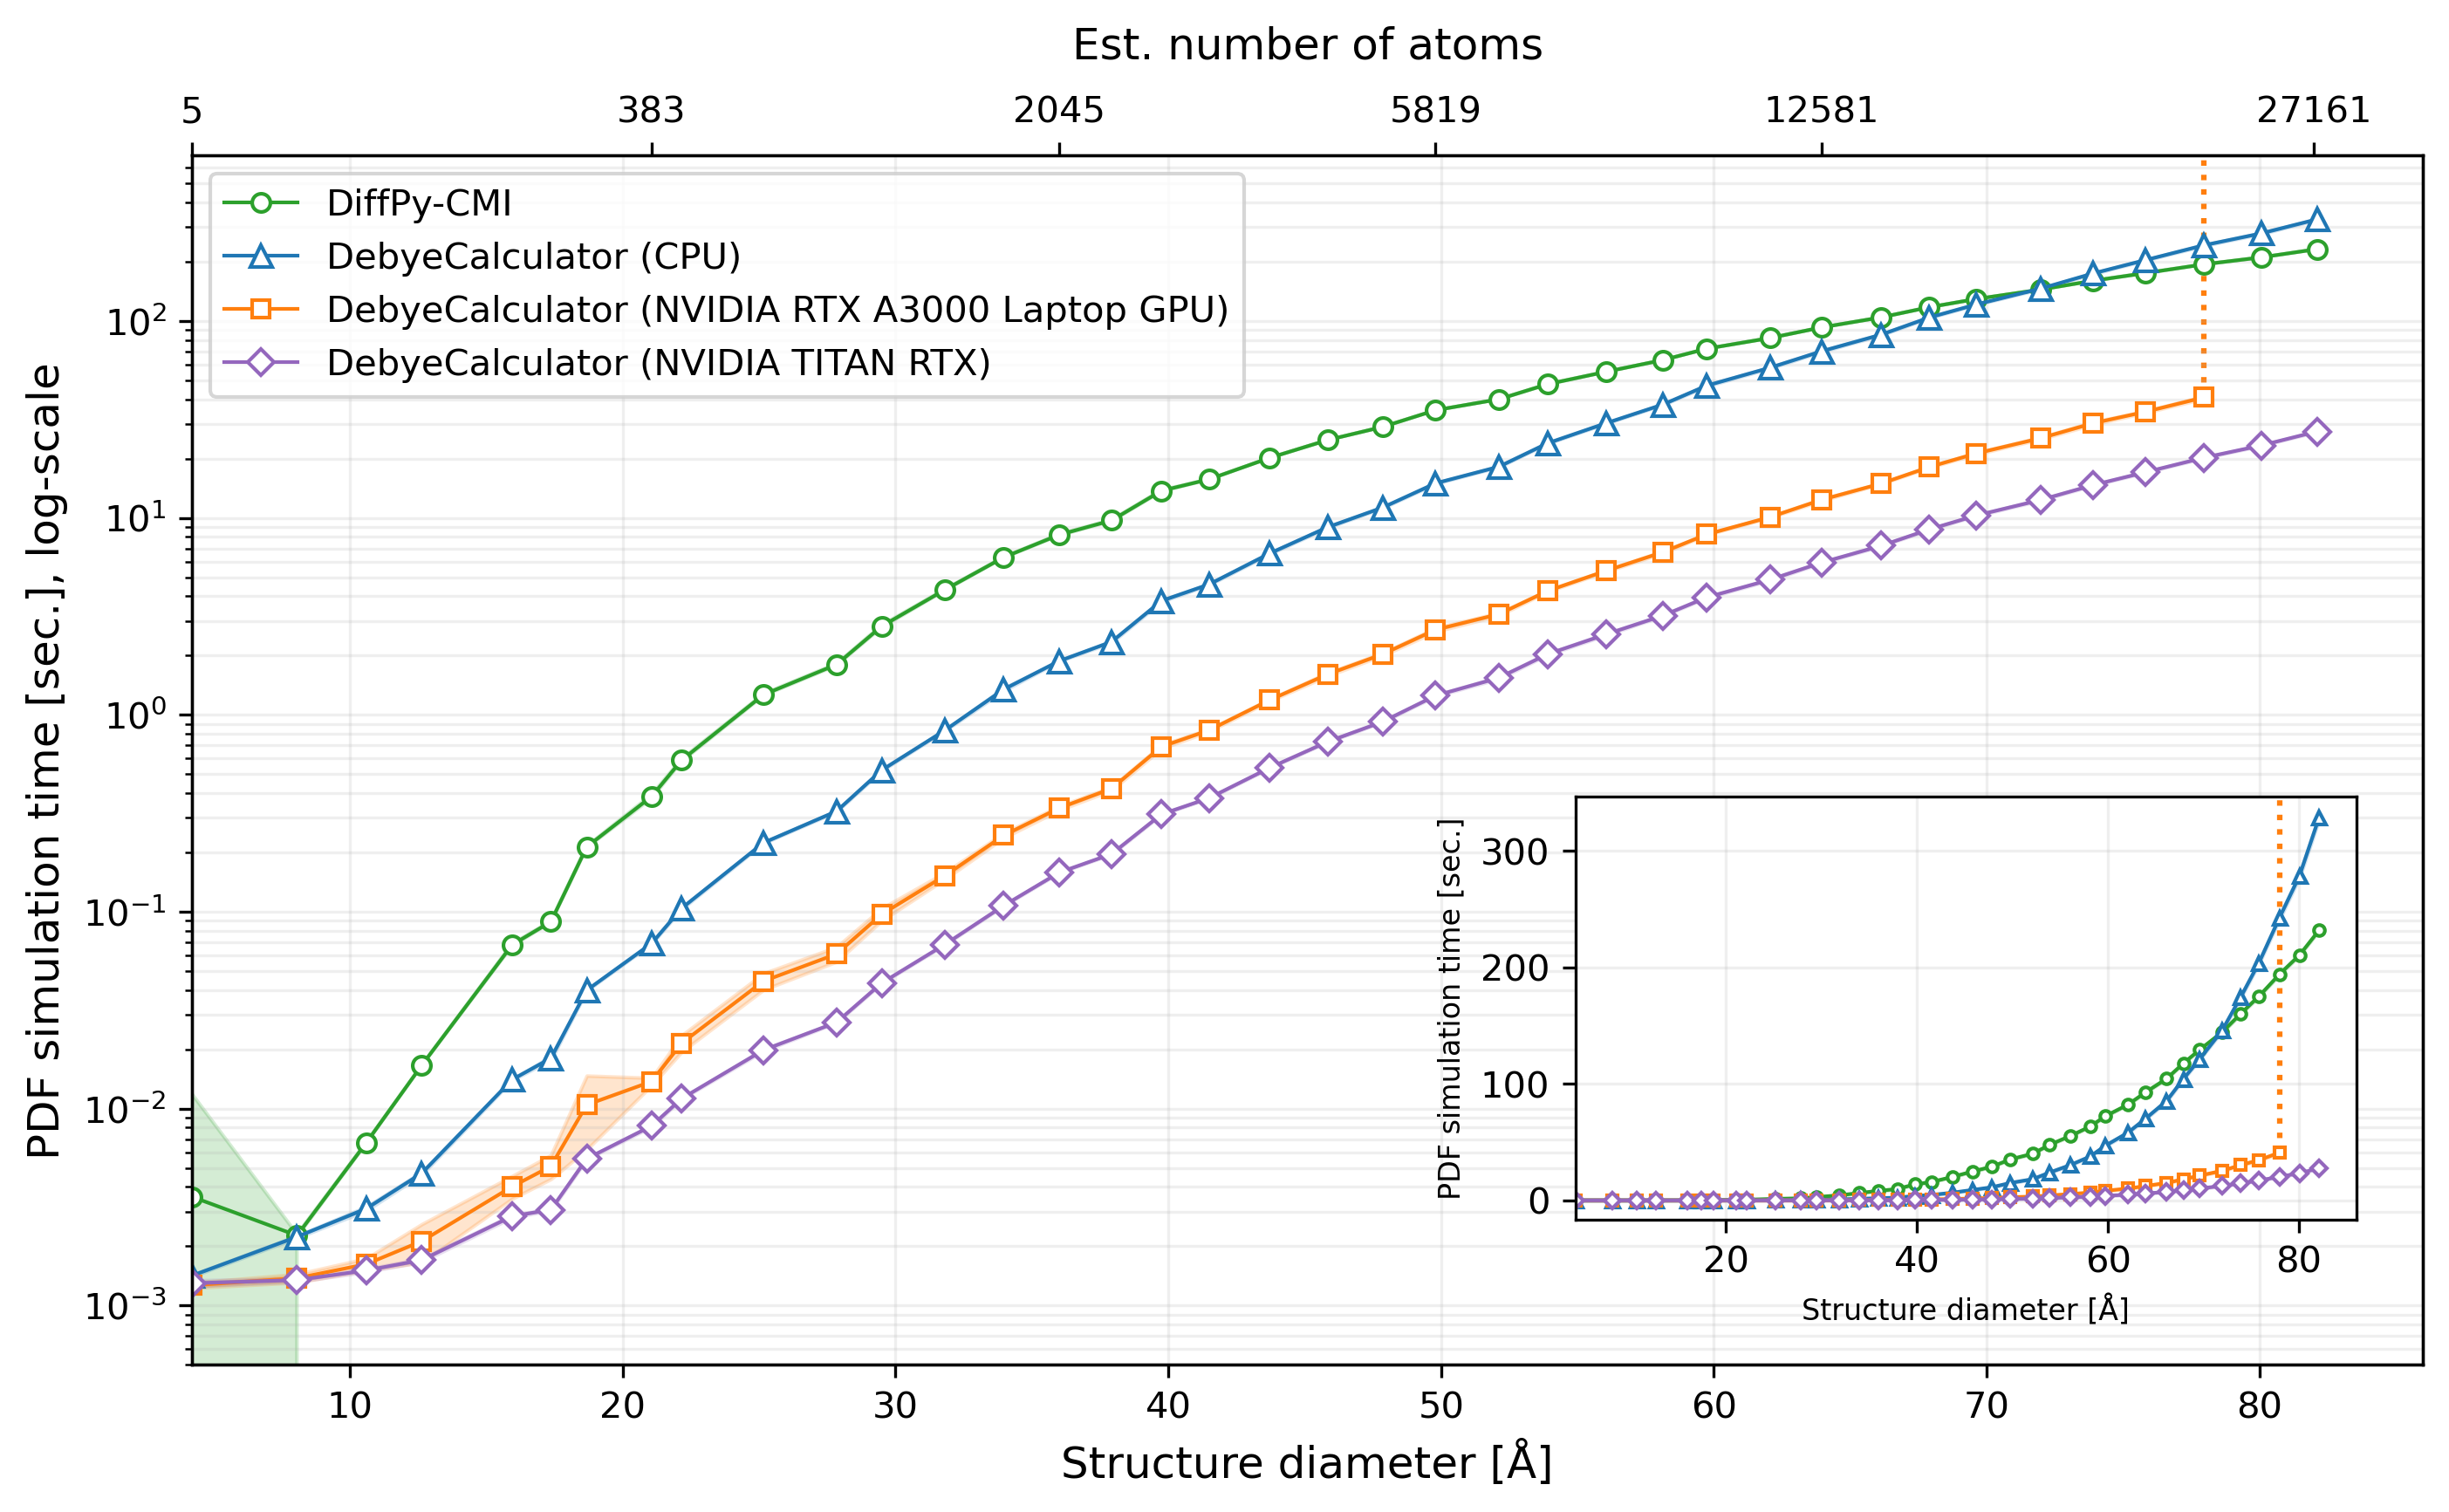

In [202]:
fig, axs = plt.subplots(figsize=(11,6), dpi=300)

ax_nonlog = axs.inset_axes([0.62, 0.12, 0.35, 0.35])

for ax, _markersize in zip([axs, ax_nonlog], [5, 3]):

    # Diffpy
    ax.plot(diffpy_data[:,0], diffpy_data[:,2], c='#2ca02c',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'DiffPy-CMI')
    ax.fill_between(diffpy_data[:,0],diffpy_data[:,2]-diffpy_data[:,3], diffpy_data[:,2]+diffpy_data[:,3], alpha=0.2, color='#2ca02c')

    # Ours CPU cluster
    ax.plot(cpu_cluster_data[:,0], cpu_cluster_data[:,2], c='#1f77b4',  marker='^', markerfacecolor='w', markersize=_markersize*1.2, lw=1, label = f'DebyeCalculator (CPU)')
    ax.fill_between(cpu_cluster_data[:,0], cpu_cluster_data[:,2]-cpu_cluster_data[:,3], cpu_cluster_data[:,2]+cpu_cluster_data[:,3], alpha=0.2, color='#1f77b4')

    # Ours GPU

    ax.plot(cuda_data[:,0], cuda_data[:,2], c='#ff7f0e', marker='s', markerfacecolor='w', markersize=_markersize, lw=1, label = f'DebyeCalculator (NVIDIA RTX A3000 Laptop GPU)')
    ax.fill_between(cuda_data[:,0], cuda_data[:,2]-cuda_data[:,3], cuda_data[:,2]+cuda_data[:,3], alpha=0.2, color='#ff7f0e')

    # Ours GPU Titan
    ax.plot(titan_data[:,0], titan_data[:,2], c='#9467bd', marker='D', markerfacecolor='w', markersize=_markersize, lw=1, label = f'DebyeCalculator (NVIDIA TITAN RTX)')
    ax.fill_between(titan_data[:,0], titan_data[:,2]-titan_data[:,3], titan_data[:,2]+titan_data[:,3], alpha=0.2, color='#9467bd')
    
    ax.grid(alpha=0.2, which="both")
    
    ylim = ax.get_ylim()
    
    ax.plot([cuda_data[:,0][0], cuda_data[:,0][0]], [cuda_data[:,2][0], cuda_data[:,2][0]*100], c='#ff7f0e', ls=':', zorder=-100)
    ax.set_xlim(diffpy_data[:,0].min(),)
    
axs.set_ylabel('PDF simulation time [sec.], log-scale', fontsize=12)
axs.set_xlabel('Structure diameter [Å]', fontsize=12)  
ax_nonlog.set_ylabel('PDF simulation time [sec.]', fontsize=8)
ax_nonlog.set_xlabel('Structure diameter [Å]', fontsize=8)  
    
axs.legend()

axs.set_yscale('log')
axs.set_ylim(5e-4, ylim[1]*2)
ax_nonlog.set_ylim(ylim[0], ylim[1])

ax_atoms = axs.twiny()
ax_atoms.set_xlim(*axs.get_xlim())
# ax_atoms.plot(cpu_cluster_data[:,1], cpu_cluster_data[:,2], alpha=1, marker='o')
ax_atoms.set_xticks(list(cpu_cluster_data[:,0][0::7][:-1]) + [int(cpu_cluster_data[:,0][-1])])
ax_atoms.set_xticklabels([int(c) for c in cpu_cluster_data[:,1][0::7][:-1]] + [int(cpu_cluster_data[:,1][-1])])
ax_atoms.set_xlabel('Est. number of atoms', fontsize=12, labelpad=10)

plt.show()

# # Save figure to paper
fig.savefig('figures/figure_1.png', dpi=300, bbox_inches='tight')

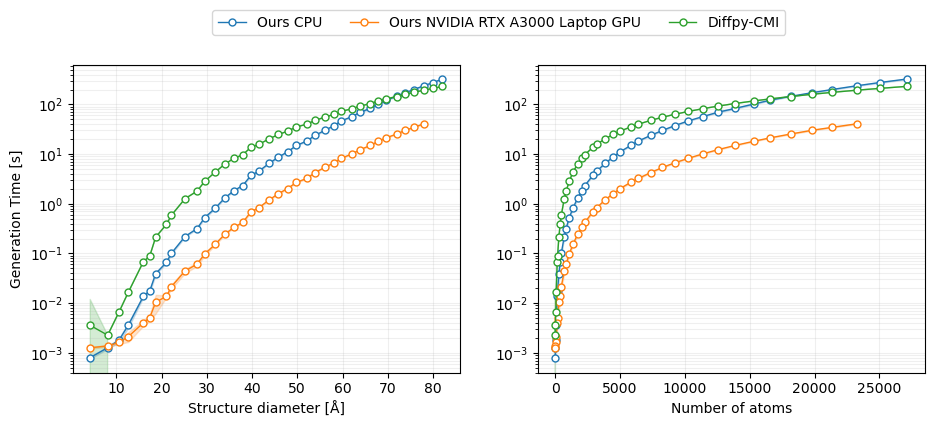

In [203]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,4))

_markersize = 5

# Ours CPU
ax1.plot(cpu_data[:,0], cpu_data[:,2], c='#1f77b4',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Ours CPU')
ax1.fill_between(cpu_data[:,0], cpu_data[:,2]-cpu_data[:,3], cpu_data[:,2]+cpu_data[:,3], alpha=0.2, color='#1f77b4')

# Ours GPU
ax1.plot(cuda_data[:,0], cuda_data[:,2], c='#ff7f0e',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Ours NVIDIA RTX A3000 Laptop GPU')
ax1.fill_between(cuda_data[:,0], cuda_data[:,2]-cuda_data[:,3], cuda_data[:,2]+cuda_data[:,3], alpha=0.2, color='#ff7f0e')

# DiffPy-CMI
ax1.plot(diffpy_data[:,0], diffpy_data[:,2], c='#2ca02c',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Diffpy-CMI')
ax1.fill_between(diffpy_data[:,0], diffpy_data[:,2]-diffpy_data[:,3], diffpy_data[:,2]+diffpy_data[:,3], alpha=0.2, color='#2ca02c')

ax1.set_ylabel('Generation Time [s]')
ax1.set_xlabel('Structure diameter [Å]')  
ax1.grid(alpha=0.2, which="both")
ax1.legend()
ax1.set_yscale('log')

# Ours CPU
ax2.plot(cpu_data[:,1], cpu_data[:,2], c='#1f77b4',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Ours CPU')
ax2.fill_between(cpu_data[:,1], cpu_data[:,2]-cpu_data[:,3], cpu_data[:,2]+cpu_data[:,3], alpha=0.2, color='#1f77b4')

# Ours GPU
ax2.plot(cuda_data[:,1], cuda_data[:,2], c='#ff7f0e',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Ours NVIDIA RTX A3000 Laptop GPU')
ax2.fill_between(cuda_data[:,1], cuda_data[:,2]-cuda_data[:,3], cuda_data[:,2]+cuda_data[:,3], alpha=0.2, color='#ff7f0e')

# DiffPy-CMI
ax2.plot(diffpy_data[:,1], diffpy_data[:,2], c='#2ca02c',  marker='o', markerfacecolor='w', markersize=_markersize, lw=1, label = f'Diffpy-CMI')
ax2.fill_between(diffpy_data[:,1], diffpy_data[:,2]-diffpy_data[:,3], diffpy_data[:,2]+diffpy_data[:,3], alpha=0.2, color='#2ca02c')

ax2.set_xlabel('Number of atoms')  
ax2.grid(alpha=0.2, which="both")
# Put a legend below current axis
ax1.legend(loc='upper center', bbox_to_anchor=(1.1, 1.2),
          fancybox=True, shadow=False, ncol=3)
ax2.set_yscale('log')
# ax2.set_xscale('log')

# fig.tight_layout()

plt.show()